In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import zscore
from sklearn.metrics import mean_squared_error

# Improving Olist's Estimated Delivery Time (ETA)

👉 `Estimated Time of Arrival (ETA)` is a key component of modern e-commerce services. It allows companies to manage customer expectations by showing a predicted date for customer delivery.

🎯 In this challenge, we will build a predictive model that `estimates the wait time` of an order.

☑️ Olist already has its own predictions under the variable `expected_wait_time`

🚀 Let's challenge ourselves to do better predictions and at the end of this recap, 
we will compare:
* our `estimated_wait_time`
* Olist's `expected_wait_time`
* the real `wait_time` for each order delivered

## Load and check `orders` dataset

👉 `Order().get_training_data()` (include `distance_seller_customer`)

In [2]:
from olist.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True)

In [3]:
orders.head(3)

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76,856.292580
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22,514.130333


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95872 entries, 0 to 95879
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  95872 non-null  object 
 1   wait_time                 95872 non-null  float64
 2   expected_wait_time        95872 non-null  float64
 3   delay_vs_expected         95872 non-null  float64
 4   order_status              95872 non-null  object 
 5   dim_is_five_star          95872 non-null  int64  
 6   dim_is_one_star           95872 non-null  int64  
 7   review_score              95872 non-null  int64  
 8   number_of_products        95872 non-null  int64  
 9   number_of_sellers         95872 non-null  int64  
 10  price                     95872 non-null  float64
 11  freight_value             95872 non-null  float64
 12  distance_seller_customer  95872 non-null  float64
dtypes: float64(6), int64(5), object(2)
memory usage: 10.2+ MB


## Baseline Model - Olist’s current ETA model

🐣  What's the baseline we want to optimize ❓

👉 The delta between Olist' `expected_wait_time` and the real `wait_time`

📈 Plot their respective histograms

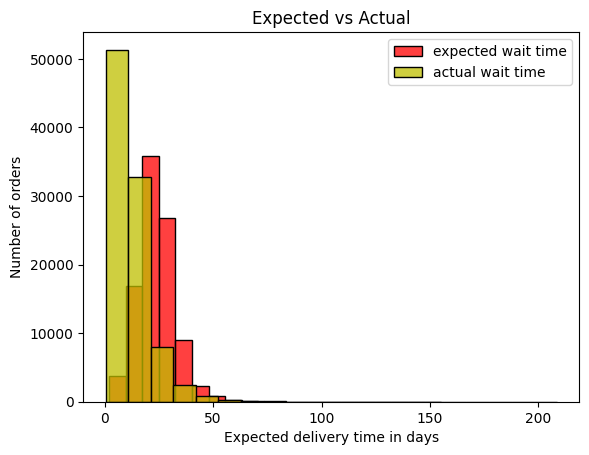

In [22]:
# YOUR CODE HERE
sns.histplot(orders["expected_wait_time"], bins=20, color="r", label="expected wait time")
sns.histplot(orders["wait_time"], bins=20, color="y", label="actual wait time")
plt.xlabel("Expected delivery time in days")
plt.ylabel("Number of orders")
plt.title("Expected vs Actual")
plt.legend()

👉 What is the median wait time ? the median expected wait time ? 

In [61]:
# YOUR CODE HERE
print("Average delivery time in days: ",orders[["expected_wait_time"]].median().round(3))

Average delivery time in days:  expected_wait_time    23.231
dtype: float64


👉 Compute the baseline RMSE 

ℹ️ The errors considered here are the misapproximations from Olist in terms of waiting time.

In [7]:
# YOUR CODE HERE
model = orders[["wait_time"]]
model = zscore(model)
model["expected_wait_time"] = orders["expected_wait_time"]
linreg = smf.ols(formula="expected_wait_time~wait_time", data=model).fit()

In [91]:
y = orders["expected_wait_time"] - orders["wait_time"]
y_pred = linreg.predict(model)
print("Baseline RMSE: ", np.sqrt(mean_squared_error(y, y_pred)).round(3))

Baseline RMSE:  17.647


## OLS multivariate model

👉 We will create an OLS model using the `statsmodel.api.OLS` method this time.

(instead of `statsmodel.formula.api.ols`) 

### Prepare the dataset with the  features X and the target Y

In [9]:
orders.corr().style.background_gradient()

,wait_time,expected_wait_time,delay_vs_expected,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
wait_time,1.000000,0.385628,0.702597,-0.234101,0.305577,-0.334036,-0.019754,-0.019754,0.055638,0.167284,0.394984
expected_wait_time,0.385628,1.000000,0.005519,-0.050333,0.034842,-0.052525,0.015735,0.015735,0.076606,0.238748,0.513583
delay_vs_expected,0.702597,0.005519,1.000000,-0.156735,0.284706,-0.272361,-0.013653,-0.013653,0.016632,0.023887,0.066066
dim_is_five_star,-0.234101,-0.050333,-0.156735,1.000000,-0.396354,0.791749,-0.072270,-0.072270,-0.012762,-0.058773,-0.056559
dim_is_one_star,0.305577,0.034842,0.284706,-0.396354,1.000000,-0.807758,0.119848,0.119848,0.044660,0.082778,0.043180
review_score,-0.334036,-0.052525,-0.272361,0.791749,-0.807758,1.000000,-0.123340,-0.123340,-0.034538,-0.090014,-0.059147
number_of_products,-0.019754,0.015735,-0.013653,-0.072270,0.119848,-0.123340,1.000000,1.000000,0.153551,0.438056,-0.017306
number_of_sellers,-0.019754,0.015735,-0.013653,-0.072270,0.119848,-0.123340,1.000000,1.000000,0.153551,0.438056,-0.017306
price,0.055638,0.076606,0.016632,-0.012762,0.044660,-0.034538,0.153551,0.153551,1.000000,0.410129,0.079348
freight_value,0.167284,0.238748,0.023887,-0.058773,0.082778,-0.090014,0.438056,0.438056,0.410129,1.000000,0.314188


In [95]:
# YOUR CODE HERE
X = orders[["distance_seller_customer","number_of_products","freight_value","dim_is_one_star","number_of_sellers"]]
Y = orders["wait_time"]

⚖️ Standardize (`z-score`) each feature of X to compare regression coefficients that will result from the OLS:

In [96]:
# YOUR CODE HERE
X = zscore(X)
X

,distance_seller_customer,number_of_products,freight_value,dim_is_one_star,number_of_sellers
0,-0.979480,-0.264596,-0.652042,-0.328966,-0.264596
1,0.429745,-0.264596,0.000467,-0.328966,-0.264596
2,-0.145496,-0.264596,-0.164054,-0.328966,-0.264596
3,2.054632,-0.264596,0.206816,-0.328966,-0.264596
4,-0.959120,-0.264596,-0.652042,-0.328966,-0.264596
...,...,...,...,...,...
95875,-0.893038,-0.264596,-0.449411,-0.328966,-0.264596
95876,-0.212798,-0.264596,-0.123156,-0.328966,-0.264596
95877,0.617633,-0.264596,1.964500,-0.328966,-0.264596
95878,-0.387560,1.601614,2.715536,-0.328966,1.601614


In [97]:
# Check how different is it from the "formula" in statsmodel
import patsy
patsy.dmatrix('price + distance_seller_customer', orders)

DesignMatrix with shape (95872, 3)
  Intercept   price  distance_seller_customer
          1   29.99                  18.06384
          1  118.70                 856.29258
          1  159.90                 514.13033
          1   45.00                1822.80037
          1   19.90                  30.17404
          1  147.90                 411.95300
          1   59.99                 321.73040
          1   19.90                 872.66930
          1  149.99                 111.51773
          1  198.00                 413.25219
          1   98.00                 844.97722
          1   31.90                 452.20571
          1   19.90                 308.45551
          1   38.25                 430.59899
          1  132.40                 161.60460
          1   27.99                 547.73905
          1   17.90                 209.39770
          1   76.00                1434.17366
          1  109.90                  11.84639
          1   79.99                  19.27366

⚠️ With this `statsmodel.api.OLS`, we always need to add a constant "intercept" to the features dataset:

In [98]:
# YOUR CODE HERE
X = sm.add_constant(X)
X

,const,distance_seller_customer,number_of_products,freight_value,dim_is_one_star,number_of_sellers
0,1.0,-0.979480,-0.264596,-0.652042,-0.328966,-0.264596
1,1.0,0.429745,-0.264596,0.000467,-0.328966,-0.264596
2,1.0,-0.145496,-0.264596,-0.164054,-0.328966,-0.264596
3,1.0,2.054632,-0.264596,0.206816,-0.328966,-0.264596
4,1.0,-0.959120,-0.264596,-0.652042,-0.328966,-0.264596
...,...,...,...,...,...,...
95875,1.0,-0.893038,-0.264596,-0.449411,-0.328966,-0.264596
95876,1.0,-0.212798,-0.264596,-0.123156,-0.328966,-0.264596
95877,1.0,0.617633,-0.264596,1.964500,-0.328966,-0.264596
95878,1.0,-0.387560,1.601614,2.715536,-0.328966,1.601614


### Run OLS with `statsmodels` and print `summary`

In [99]:
# YOUR CODE HERE
X["wait_time"] = orders["wait_time"]
linreg_x = smf.ols(formula="wait_time~distance_seller_customer+number_of_products+freight_value+dim_is_one_star",
                  data=X).fit()
linreg_x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wait_time   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     7757.
Date:                Tue, 18 Apr 2023   Prob (F-statistic):               0.00
Time:                        14:30:20   Log-Likelihood:            -3.3797e+05
No. Observations:               95872   AIC:                         6.760e+05
Df Residuals:                   95867   BIC:                         6.760e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   12.5134      0.027    471.460      0.000      12.461      12.565
distance_seller_customer     3.4153      0.028    120.051      0.000       3.359       3.471
number_of_products          -0.7211      0.030    -23.902      0.000      -0.780      -0.662
freight_value                0.5945      0.032     18.796      0.000       0.532       0.656
dim_is_one_star              2.7789      0.027    103.818      0.000       2.726       2.831
==============================================================================
Omnibus:                    90982.366   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12560453.661
Skew:                           4.204   Prob(JB):                         0.00
Kurtosis:                      58.440   Cond. No.                         1.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Check the performance of your OLS model

### Goodness of fit

👉 Who has the best predictions, you or Olist ? 

- Compute your predictions and store them in `y_pred`

- You can store :
    - Olist's predictions in a `y_expected_olist` variable
    - the real waiting times in a `y_true` variable



In [100]:
# YOUR CODE HERE
y_pred = linreg_x.predict(X)
y_expected_olist = orders["expected_wait_time"]
y_true = orders["wait_time"]

📈 Plot `y_pred`, `y_expected_olist` and `y_true` on the same graph.

Text(0.5, 1.0, 'Me vs Olist vs Actual')

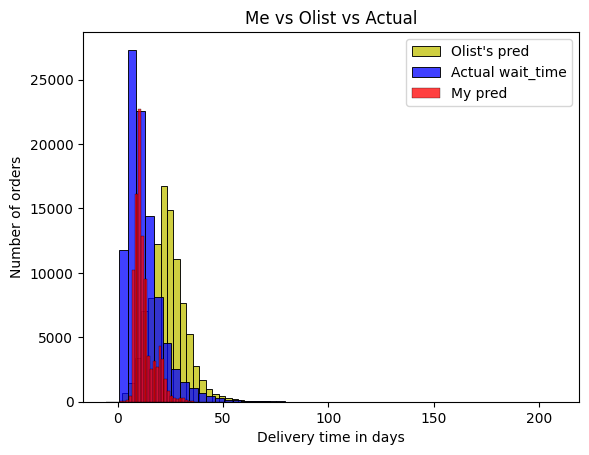

In [101]:
# YOUR CODE HERE
sns.histplot(y_expected_olist, bins=50, color="y", label="Olist's pred")
sns.histplot(y_true, bins=50, color="b", label="Actual wait_time")
sns.histplot(y_pred, bins=50, color="r", label="My pred")
plt.xlabel("Delivery time in days")
plt.ylabel("Number of orders")
plt.legend()
plt.title("Me vs Olist vs Actual")

👉 Compute the RMSE where the errors are now *your* errors !

In [105]:
# YOUR CODE HERE
Y = y_pred - y_true
print("MY RMSE: ", np.sqrt(mean_squared_error(Y, y_pred)).round(3))

MY RMSE:  15.684


Just as a reminder, Olist's RMSE was equal to : 👇

In [106]:
y = orders["expected_wait_time"] - orders["wait_time"]
y_pred = linreg.predict(model)
print("Baseline RMSE: ", np.sqrt(mean_squared_error(y, y_pred)).round(3))

Baseline RMSE:  17.647


😏 Did we really beat Olist's Data Scientists ? We cannot really say that!

- In many e-commerce and delivery services, the ETA is often overestimated...
- When customers receive their orders earlier than expected, they are more likely to be satisfied !

### Partial correlations

👉 Visualize partial correlations with `sm.graphics.plot_partregress_grid`

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


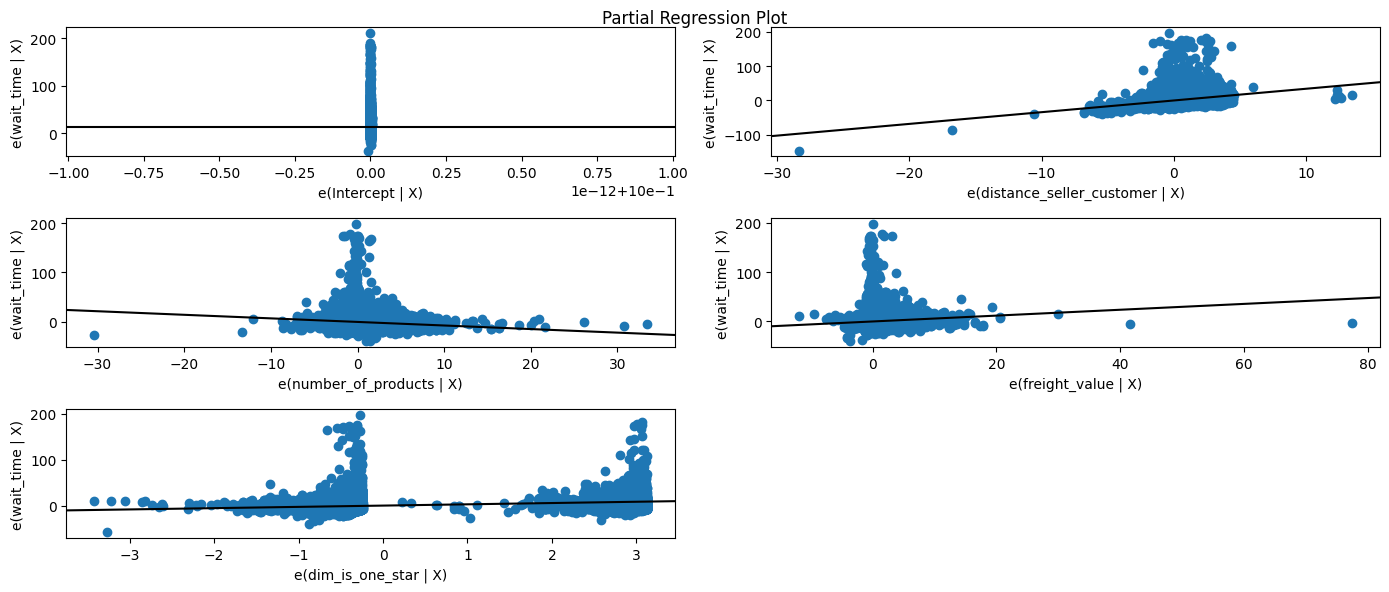

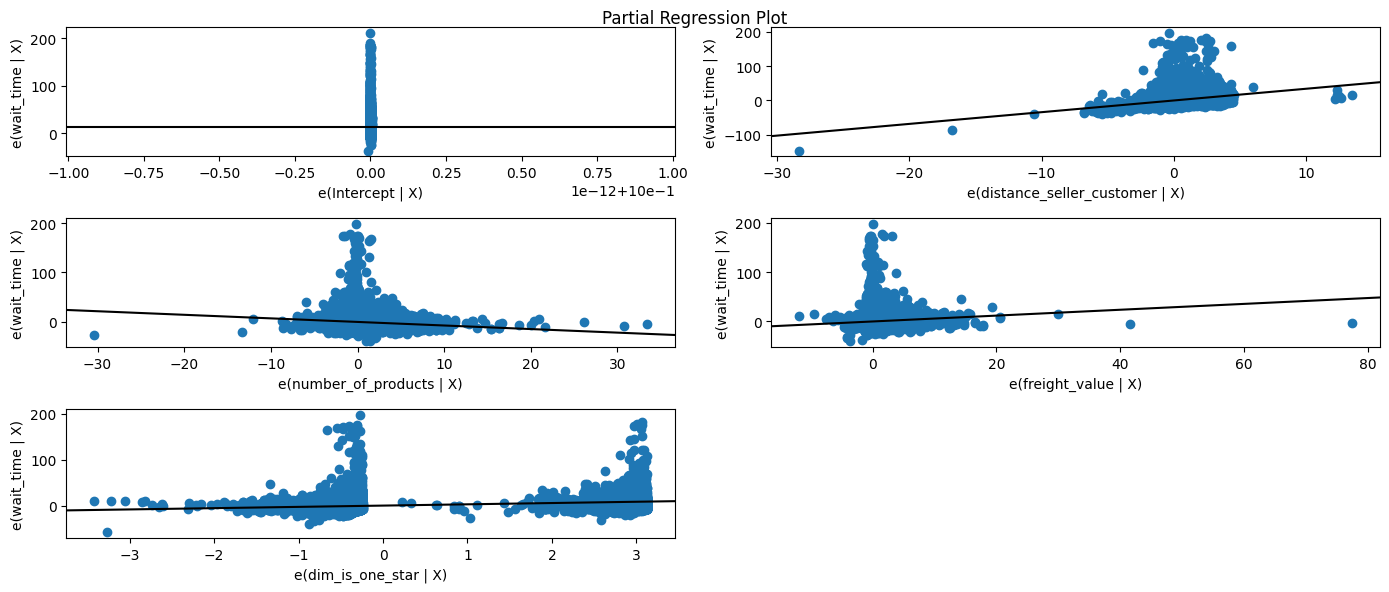

In [107]:
# YOUR CODE HERE
fig = plt.figure(figsize=(14,6))
sm.graphics.plot_partregress_grid(linreg_x, fig=fig)

**How do we read these graphs ?**

👉 Let's focus - for instance - on the graph in the bottom left corner:

<u>Partial regression of `wait_time` against `distance`</u>

- Each point is an order in our dataset


- `y-axis`: residuals of the `wait_time`, using all features except `distance`

    - These residuals contain the remaining information about `wait_time` that couldn't be explained without `distance`


- `x-axis`: residuals of predicting `distance` by using all other features (price, freight_value, etc...)
    - These residuals contain the new information that `distance` brings to the table, which is not already explained by the other features in the model.



### Inferential conditions

⚠️ Check you residuals. Are they normally distributed?

<AxesSubplot:ylabel='Density'>

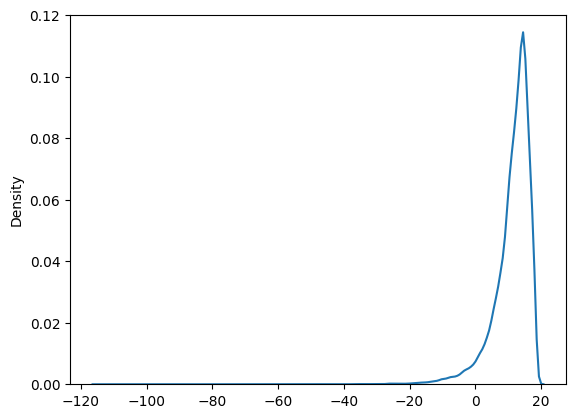

In [113]:
# YOUR CODE HERE
sns.kdeplot(Y)

🎁 A more precise way to visualize whether a distribution is Gaussian or not is the <a href="https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html">**`QQplot`**</a>. 

📈 Plot the QQplot of your residual below

💡 Make sure to understand the relation between the QQ plot and the density previsouly drawn..

📚 <a href="https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot">Stats.StackExchange.com - Interpreting QQplots</a>

- `x-axis` : theoretical quantiles of a Gaussian distribution
- `y-axis`: quantiles of the sorted variable

💡 If the <span style="color:blue">blue</span> points are aligned on the <span style="color:red">red line</span> which is the identity function, the variable has a Gaussian distribution !

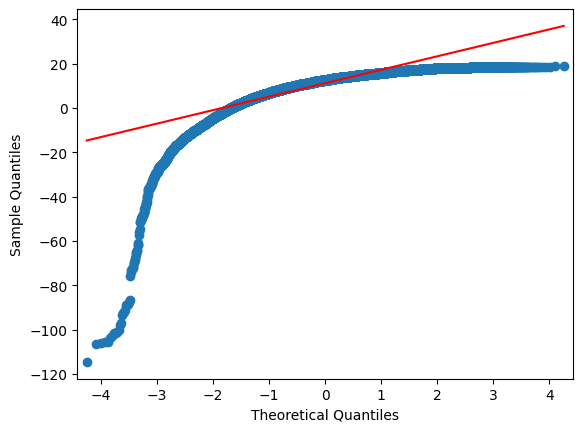

In [114]:
sm.qqplot(Y, line='s');

#### Some QQplot examples:

Run the cells below to understand how QQ plots are graphed:

In [115]:
from scipy import stats 
stats.norm.rvs(0,1)

-0.8505960434055722

(-4.526347106347011, 10.0)

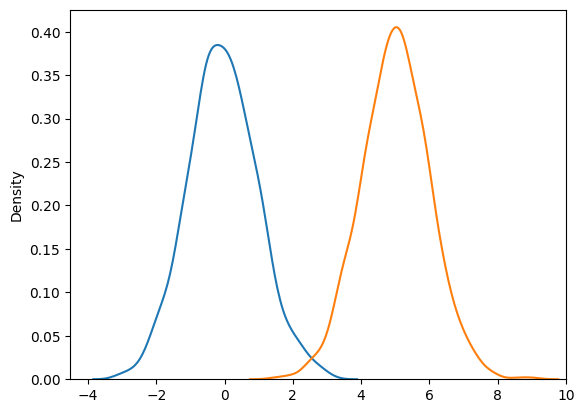

In [116]:
# lets check QQ plots with our own distributions
from scipy import stats

norm_1 = [stats.norm.rvs(0,1) for x in range(1000)]
norm_2 = [stats.norm.rvs(5,1) for x in range(1000)]

sns.kdeplot(norm_1)
sns.kdeplot(norm_2)
plt.xlim(right=10)

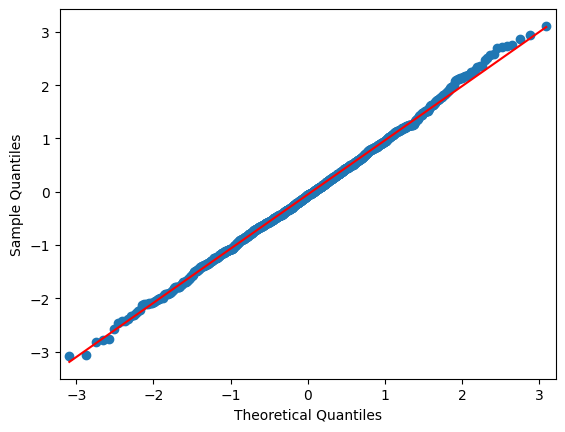

In [117]:
sm.qqplot(np.asarray(norm_1), line='s');

(-5.648397017739913, 10.0)

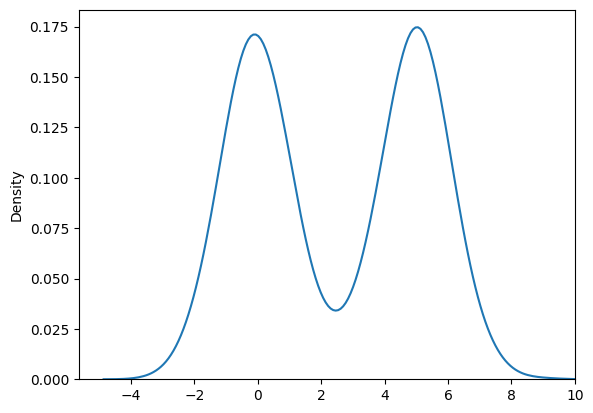

In [118]:
bimodal = norm_1 + norm_2
sns.kdeplot(bimodal)
plt.xlim(right=10)

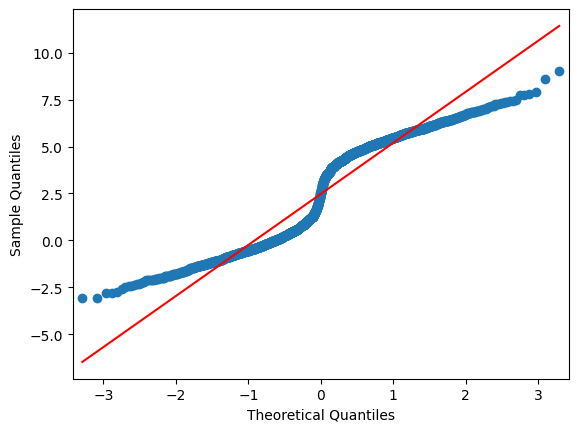

In [119]:
sm.qqplot(np.asarray(bimodal), line='s');

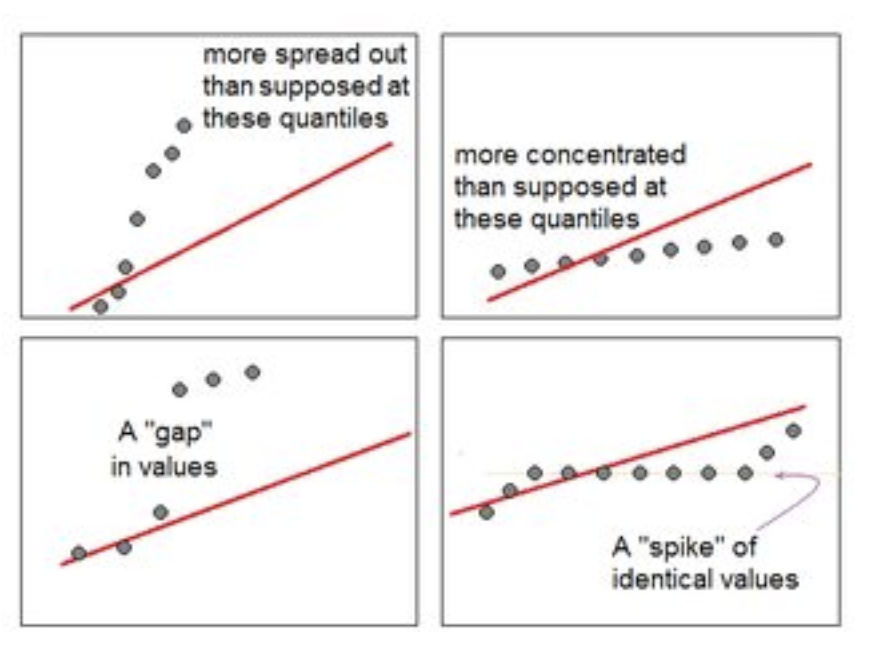

#### Check residuals vs. fitted to see if we can detect any non-random pattern

(0.0, 50.0)

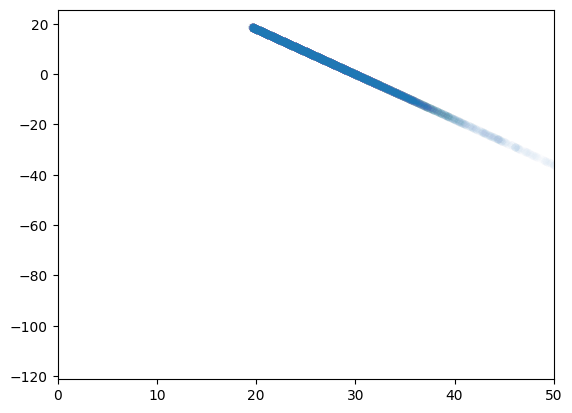

In [121]:
sns.scatterplot(x = y_pred, y = Y, alpha=0.01)
plt.xlim(xmin=0, xmax=50)

## More Features? (Optional)

Here we can add additional features from the product details (size, category etc..)

### Add product details associated with each order (sum of product sizes, sum of weights etc...)

In [122]:
from olist.data import Olist
data = Olist().get_data()
products = data['products']
order_items = data['order_items']

In [ ]:
order_items_products = (
    order_items.groupby(["order_id", "product_id"], as_index=False)
    .agg({"order_item_id": "count"})
    .rename(columns={"order_item_id": "order_item_count"})
    .merge(products.drop(["product_category_name"], axis=1), on="product_id")
)
order_items_products

In [ ]:
# Since we want the sum of product weights per order from our new DataFrame, we need to multiply weight by product count
order_items_products['product_weight_g'] = order_items_products['product_weight_g'] *  order_items_products['order_item_count']

order_items_features = order_items_products.groupby("order_id", as_index=False).agg(
    {
        "product_weight_g": "sum",
        "product_length_cm": "max",
        "product_height_cm": "max",
        "product_width_cm": "max",
    }).rename(columns={
        "product_weight_g": "product_weight_g_sum",
        "product_length_cm": "product_length_cm_max",
        "product_height_cm": "product_height_cm_max",
        "product_width_cm": "product_width_cm_max",
    })
order_items_features

In [ ]:
orders_with_details = orders.merge(order_items_features, on="order_id", how="left").dropna()

In [ ]:
X2 = orders_with_details[[
        "number_of_products",
        "number_of_sellers",
        "price",
        "freight_value",
        "distance_seller_customer",
        "product_weight_g_sum",
        "product_length_cm_max",
        "product_height_cm_max",
        "product_width_cm_max"]].copy()
y2 = orders_with_details["wait_time"].copy()

In [ ]:
# standardize (z-normalize) each features of X to compare coefficients
for f in X2.columns:
    mu = X2[f].mean()
    sigma = X2[f].std()
    X2[f] = X2[f].map(lambda x: (x - mu) / sigma)

In [ ]:
X2['constant'] = 1

In [ ]:
model2 = sm.OLS(y2, X2).fit()

In [ ]:
model2.summary()